# Helper functions

In [1]:
import re

import pandas as pd


def data_preparation(df: pd.DataFrame, keep_ratio: float = 0.8) -> pd.DataFrame:
    stats = (
        df.groupby(["Module", "Function"])
        .agg(
            mean_cpu=pd.NamedAgg(column="CPU Time", aggfunc="mean"),
            std_cpu=pd.NamedAgg(column="CPU Time", aggfunc="std"),
            mean_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="mean"),
            std_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="std"),
            mean_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="mean"),
            std_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="std"),
        )
        .sort_values(by="mean_cpu", ascending=False)
    )
    stats["perc_makespan"] = stats["mean_cpu"] / stats["mean_cpu"].sum() * 100
    stats["cumperc_makespan"] = stats["perc_makespan"].cumsum()
    hotspots = stats[
        stats["cumperc_makespan"] <= max(keep_ratio * 100, stats["cumperc_makespan"][0])
    ]

    # Total CPU Time per module
    module_mean_cpu = hotspots.groupby("Module")["mean_cpu"].sum().to_dict()
    hotspots = hotspots.reset_index()
    hotspots["module_cpu"] = hotspots["Module"].map(module_mean_cpu)

    # Clean Function and Module names
    def module_short(module: str) -> str:
        if m := re.match(r"^\w+\.so", module):
            return m.group(0)
        return module

    hotspots["func_short"] = hotspots["Function"].apply(
        lambda x: re.sub(r"<.*>", "", x)
    )
    hotspots["module_short"] = hotspots["Module"].apply(module_short)

    # CPU Time sorted by "Module CPU Time" -> "CPU Time".
    hotspots = hotspots.sort_values(by=["module_cpu", "mean_cpu"], ascending=False)
    # Reorder the cumulative makespan for plotting.
    hotspots["cumperc_makespan"] = hotspots["perc_makespan"].cumsum()
    hotspots = hotspots.reset_index()
    hotspots.index += 1

    return hotspots

In [2]:
import math

from bokeh.models import (
    ColorBar,
    ColumnDataSource,
    FactorRange,
    HoverTool,
    LabelSet,
    LinearAxis,
    LinearColorMapper,
    Range1d,
    Whisker,
)
from bokeh.plotting import figure, show
from bokeh.transform import transform


def plot_hotspots(
    data: pd.DataFrame,
    *,
    y_limit: float | None = None,
    nthreads: int | None = None,
    colorbar_color: str = "Plasma256",
    colorbar_on: str,
    colorbar_title: str,
    pipeline: str,
):
    xs = [(module, str(i)) for i, module in enumerate(data["module_short"], start=1)]
    source = ColumnDataSource(
        data=dict(
            x=xs,
            module=data["Module"].values,
            func=data["Function"].values,
            module_short=data["module_short"].values,
            func_short=data["func_short"].values,
            func_id=data.index.values,
            perc_makespan=data["perc_makespan"].values,
            cumperc_makespan=data["cumperc_makespan"].values,
            mean_cpu=data["mean_cpu"].values,
            std_cpu=data["std_cpu"].values,
            std_lower_cpu=data["mean_cpu"].values - data["std_cpu"].values,
            std_upper_cpu=data["mean_cpu"].values + data["std_cpu"].values,
            mean_mem_bound=data["mean_mem_bound"].values,
            std_mem_bound=data["std_mem_bound"].values,
            mean_fp=data["mean_fp"].values,
            std_fp=data["std_fp"].values,
        )
    )

    p = figure(
        x_range=FactorRange(*xs),
        title=(
            f"Avg. CPU Time (seconds): {pipeline}"
            + (f" with {str(nthreads)} threads" if nthreads else "")
        ),
        width=1500,
        toolbar_location=None,
    )

    # Tools
    hover = HoverTool()
    hover.tooltips = [
        ("Module", "@module"),
        # ("Function", "@func"),
        ("Module (short)", "@module_short"),
        ("Function (short)", "@func_short"),
        ("Function ID", "@func_id"),
        ("Makespan contribution", "@perc_makespan{1.1}%"),
        ("Makespan contribution (cumulative)", "@cumperc_makespan{1.1}%"),
        ("CPU Time (mean ± std)", "@mean_cpu{1.11} ± @std_cpu{1.11}"),
        (
            "% of memory bound (mean ± std)",
            "@mean_mem_bound{1.11} ± @std_mem_bound{1.11}",
        ),
        ("% of FP ops (mean ± std)", "@mean_fp{1.11} ± @std_fp{1.11}"),
    ]
    p.tools.append(hover)

    # Mean
    color_mapper = LinearColorMapper(palette=colorbar_color, low=0, high=100)
    color_bar = ColorBar(
        color_mapper=color_mapper,
        label_standoff=14,
        location=(0, 0),
        title=colorbar_title,
        title_text_font_size="20pt",
    )
    p.add_layout(color_bar, "left")
    p.vbar(
        x="x",
        top="mean_cpu",
        width=0.9,
        source=source,
        color=transform(colorbar_on, color_mapper),
    )
    # Error
    error = Whisker(
        base="x",
        upper="std_upper_cpu",
        lower="std_lower_cpu",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Cumulative makespan
    p.extra_y_ranges = {"percentage": Range1d(start=0, end=100)}
    p.add_layout(
        LinearAxis(y_range_name="percentage", axis_label="Cumulative makespan (%)"),
        "right",
    )
    p.scatter(
        x="x",
        y="cumperc_makespan",
        source=source,
        y_range_name="percentage",
        color="lightgreen",
        size=10,
    )

    # # Bar labels
    # labels = LabelSet(
    #     x="x",
    #     y=0,
    #     text="func_short",
    #     x_offset=0,
    #     y_offset=0,
    #     angle=math.pi / 2,
    #     source=source,
    #     text_color="black",
    #     text_font_size="0.8em",
    #     background_fill_color="white",
    #     background_fill_alpha=0.5,
    # )
    # p.add_layout(labels)

    # Style
    if not y_limit:
        y_limit = 1.05 * (data["mean_cpu"].values + data["std_cpu"].values).max()
    p.y_range.end = y_limit
    p.y_range.start = 0
    # p.y_range = Range1d(start=0, end=y_limit)
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = math.pi / 2
    p.xaxis.group_label_orientation = math.pi / 8
    p.xaxis.separator_line_alpha = 0
    p.xgrid.grid_line_color = None
    p.yaxis.formatter.use_scientific = False

    ## Font size
    p.title.text_font_size = "25pt"
    p.xaxis.group_text_font_size = "12pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "15pt"

    # Prevent overlap of x-axis labels
    if (l := len(data)) > 120:
        p.xaxis.major_label_text_font_size = "6pt"
    elif l > 80:
        p.xaxis.major_label_text_font_size = "8pt"
    else:
        p.xaxis.major_label_text_font_size = "12pt"

    return p

In [3]:
from pathlib import Path

from bokeh.palettes import Colorblind8
from bokeh.transform import factor_cmap


def plot_cpu_time(path: Path, *, nthreads: int = 1, dataset=None):
    # Data preparation
    data = pd.concat(
        (
            pd.read_csv(filename, delimiter="\t").assign(
                filename=filename.stem,
                pipeline="/".join(filename.relative_to(path).parts[:2]),
            )
            for filename in path.rglob(f"**/{dataset}/**/*.csv" if dataset else "*.csv")
        ),
        ignore_index=True,
    )

    group = (
        data.groupby(["pipeline", "filename"])["CPU Time"]
        .sum()
        .divide(nthreads)
        .groupby("pipeline")
        .agg(["mean", "std"])
    )

    source = ColumnDataSource(
        data=dict(
            pipeline=group.index.values,
            mean=group["mean"].values,
            std=group["std"].values,
            std_lower=group["mean"].values - group["std"].values,
            std_upper=group["mean"].values + group["std"].values,
        )
    )

    # Plotting
    cmap = factor_cmap(
        "pipeline", palette=Colorblind8, factors=sorted(data["pipeline"].unique())
    )
    p = figure(
        x_range=group.index.values,
        width=1500,
        toolbar_location=None,
        y_axis_label="Total CPU time (seconds)",
    )

    p.vbar(
        x="pipeline",
        top="mean",
        width=0.9,
        source=source,
        line_color=cmap,
        fill_color=cmap,
    )
    # Error
    error = Whisker(
        base="pipeline",
        upper="std_upper",
        lower="std_lower",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Tools
    hover = HoverTool()
    hover.tooltips = [
        ("Pipeline", "@pipeline"),
        ("Makespan (mean ± std)", "@mean{1.11} ± @std{1.11}"),
    ]
    p.tools.append(hover)

    # Appearance
    p.left[0].formatter.use_scientific = False
    p.y_range.end = 1.05 * (group["mean"].values + group["std"].values).max()
    p.y_range.start = 0
    p.xaxis.major_label_orientation = math.pi / 8
    p.xgrid.grid_line_color = None
    p.outline_line_color = None

    ## Font size
    p.xaxis.major_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "20pt"

    return p


In [4]:
from collections import defaultdict
from pathlib import Path

from bokeh.palettes import Colorblind8
from bokeh.transform import factor_cmap
import numpy as np


def parse_makespan(filename):
    df = pd.read_csv(filename, delimiter="\t", on_bad_lines="skip")
    return float(df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0])


def plot_makespan(path: Path, *, nthreads: int = 1, dataset=None):
    # Data preparation
    data = defaultdict(list)
    for filename in path.rglob(
        f"**/{dataset}/**/*.makespan" if dataset else "*.makespan"
    ):
        pipeline = "/".join(filename.relative_to(path).parts[:2])
        data[pipeline].append(parse_makespan(filename))

    pipelines = sorted(data.keys())
    means = np.array([np.mean(data[pipeline]) for pipeline in pipelines])
    stds = np.array([np.std(data[pipeline]) for pipeline in pipelines])

    source = ColumnDataSource(
        data=dict(
            pipeline=pipelines,
            mean=means,
            std=stds,
            std_lower=means - stds,
            std_upper=means + stds,
        )
    )

    # Plotting
    cmap = factor_cmap("pipeline", palette=Colorblind8, factors=pipelines)
    p = figure(
        x_range=pipelines,
        width=1500,
        toolbar_location=None,
        y_axis_label="Makespan (seconds)",
    )

    p.vbar(
        x="pipeline",
        top="mean",
        width=0.9,
        source=source,
        line_color=cmap,
        fill_color=cmap,
    )
    # Error
    error = Whisker(
        base="pipeline",
        upper="std_upper",
        lower="std_lower",
        source=source,
        level="annotation",
        line_width=2,
    )
    error.upper_head.size = 20
    error.lower_head.size = 20
    p.add_layout(error)

    # Tools
    hover = HoverTool()
    hover.tooltips = [
        ("Pipeline", "@pipeline"),
        ("Makespan (mean ± std)", "@mean{1.11} ± @std{1.11}"),
    ]
    p.tools.append(hover)

    # Appearance
    p.left[0].formatter.use_scientific = False
    p.y_range.end = 1.05 * (means + stds).max()
    p.y_range.start = 0
    p.xaxis.major_label_orientation = math.pi / 8
    p.xgrid.grid_line_color = None
    p.outline_line_color = None

    ## Font size
    p.xaxis.major_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.yaxis.major_label_text_font_size = "20pt"

    return p


In [5]:
import socket
import warnings

from selenium import webdriver


class remote_driver:
    def __enter__(self):
        options = webdriver.ChromeOptions()
        options.add_argument("--headless")
        options.add_argument("--window-size=1920,1080")
        options.add_argument("--ignore-ssl-errors=yes")
        options.add_argument("--ignore-certificate-errors")

        remote = socket.gethostbyname(socket.gethostname()) + ":4444"
        try:
            self.driver = webdriver.Remote(remote, options=options)
            self.driver.maximize_window()
            return self.driver
        except:
            warnings.warn("Failed to initialize Selenium webdriver.")
            return None

    def __exit__(self, exc_type, exc_value, exc_tb):
        if hasattr(self, "driver"):
            self.driver.quit()


In [6]:
from typing import Optional


from bokeh.io import export_png
from bokeh.plotting import output_file, save


def show_and_export(
    p: figure,
    *,
    fout: Optional[Path] = None,
    driver: Optional[webdriver.Remote] = None,
    hide_title: bool = False,
):
    if fout:
        if hide_title:
            p.title = ""
        fout.parent.mkdir(parents=True, exist_ok=True)
        export_png(p, filename=fout.as_posix()+".png", webdriver=driver)

        # Save HTML file
        output_file(filename=fout.as_posix()+".html")
        save(p)

    else:
        return show(p)

In [7]:
def read_profiling_data(path: Path, *, delimiter: str = "\t") -> pd.DataFrame:
    return pd.concat(
        (
            pd.read_csv(filename, delimiter=delimiter)
            for filename in path.rglob("*.csv")
        ),
        ignore_index=True,
    )


# Results

In [8]:
from bokeh.io import output_notebook


output_notebook()

figures_dir = Path("paper", "figures")
figures_dir.mkdir(parents=True, exist_ok=True, mode=0o755)

tables_dir = Path("paper", "tables")
tables_dir.mkdir(parents=True, exist_ok=True, mode=0o755)

profiling_dir = Path(
    "/", "mnt", "lustre", "mathdugre", "mri-bottleneck", "vtune_output"
)
dataset = "ds004513"
VERBOSE = False

Loading BokehJS ...

## Single-threaded

In [9]:
with remote_driver() as driver:
    show_and_export(
        plot_makespan(profiling_dir / "1-threads", dataset=dataset),
        fout=figures_dir / "makespan-1thread",
        driver=driver,
    )

/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [10]:
with remote_driver() as driver:
    show_and_export(
        plot_cpu_time(profiling_dir / "1-threads", dataset=dataset),
        fout=figures_dir / "cpu-time-1thread",
        driver=driver,
    )

/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [11]:
dataset = "ds004513"
experiments: dict[str, tuple[tuple[str, float | None]]] = {
    "ants": (
        ("brainExtraction", 700),
        ("brainExtraction-fp", 700),
        ("registrationSyN", 2200),
        ("registrationSyN-fp", 2200),
    ),
    "fsl": (
        ("fast", None),
        ("mcflirt", None),
        ("flirt", None),
    ),
    "freesurfer": (("reconall", None),),
    # "fmriprep": (("full", None),),
}

with remote_driver() as driver:
    for toolkit, pipelines in experiments.items():
        for pipeline, y_limit in pipelines:
            profiling_data = read_profiling_data(
                profiling_dir / "1-threads" / toolkit / pipeline / dataset
            )
            data = data_preparation(profiling_data, keep_ratio=0.8)
            p = plot_hotspots(
                data,
                pipeline=f"{toolkit}.{pipeline}",
                y_limit=y_limit,
                nthreads=1,
                colorbar_on="mean_mem_bound",
                colorbar_title="% of memory bound",
                colorbar_color="Plasma256",
            )

            _filename = f"hotspots-1thread-{toolkit}-{pipeline}"
            show_and_export(
                p,
                fout=figures_dir / f"{_filename}",
                driver=driver,
            )

            out_data = data[["module_short", "func_short", "mean_cpu", "std_cpu"]]
            out_data.to_csv(tables_dir / f"{_filename}.csv")
            if VERBOSE:
                print(out_data.head(10).to_string())


/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")
/tmp/ipykernel_1041777/3783507059.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats["cumperc_makespan"] <= max(keep_ratio * 100, stats["cumperc_makespan"][0])
/tmp/ipykernel_1041777/3783507059.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats["cumperc_makespan"] <= max(keep_ratio * 100, stats["cumperc_makespan"][0])
/tmp/ipykernel_1041777/3783507059.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

## Multi-threaded (32 threads)

In [12]:
with remote_driver() as driver:
    show_and_export(
        plot_makespan(profiling_dir / "32-threads", nthreads=32, dataset=dataset),
        fout=figures_dir / "makespan-32threads",
        driver=driver,
    )

/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [13]:
with remote_driver() as driver:
    show_and_export(
        plot_cpu_time(profiling_dir / "32-threads", nthreads=32, dataset=dataset),
        fout=figures_dir / "cpu-time-32threads",
        driver=driver,
    )

/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


In [14]:
experiments: dict[str, tuple[tuple[str, float | None]]] = {
    "ants": (
        ("brainExtraction", 1100),
        ("brainExtraction-fp", 1100),
        ("registrationSyN", 3000),
        ("registrationSyN-fp", 3000),
    ),
    "fsl": (
        ("fast", None),
        ("mcflirt", None),
        ("flirt", None),
    ),
    "freesurfer": (("reconall", None),),
    # "fmriprep": (("full", None),),
}

with remote_driver() as driver:
    for toolkit, pipelines in experiments.items():
        for pipeline, y_limit in pipelines:
            profiling_data = read_profiling_data(
                profiling_dir / "32-threads" / toolkit / pipeline
            )
            data = data_preparation(profiling_data, keep_ratio=0.8)
            p = plot_hotspots(
                data,
                pipeline=f"{toolkit}.{pipeline}",
                y_limit=y_limit,
                nthreads=32,
                colorbar_on="mean_mem_bound",
                colorbar_title="% of memory bound",
                colorbar_color="Plasma256",
            )

            _filename = f"hotspots-32threads-{toolkit}-{pipeline}"
            show_and_export(
                p,
                fout=figures_dir / f"{_filename}",
                driver=driver,
            )
            out_data = data[["module_short", "func_short", "mean_cpu", "std_cpu"]]
            out_data.to_csv(tables_dir / f"{_filename}.csv")
            if VERBOSE:
                print(out_data.head(10).to_string())

/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")
/tmp/ipykernel_1041777/3783507059.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats["cumperc_makespan"] <= max(keep_ratio * 100, stats["cumperc_makespan"][0])
/tmp/ipykernel_1041777/3783507059.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats["cumperc_makespan"] <= max(keep_ratio * 100, stats["cumperc_makespan"][0])
/tmp/ipykernel_1041777/3783507059.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

# FreeSurfer threading

In [15]:
nthreads = (1, 2, 4, 8, 16, 32)
freesurfer_threading = [
    list(
        profiling_dir.glob(
            f"{i}-threads/freesurfer/reconall/ds004513/sub-s036/*.makespan"
        )
    )[0]
    for i in nthreads
]

# Data preparation
pipelines = [
    "/".join(filename.relative_to(profiling_dir).parts[:2])
    for filename in freesurfer_threading
]
makespans = [parse_makespan(filename) for filename in freesurfer_threading]
speedups = [makespans[0] / makespan for makespan in makespans]
efficiencies = [speedup / nthread * 100 for nthread, speedup in zip(nthreads, speedups)]

source = ColumnDataSource(
    data=dict(
        nthread=nthreads,
        pipeline=pipelines,
        makespan=makespans,
        speedup=[np.nan] + speedups[1:],
        efficiency=[np.nan] + efficiencies[1:],
    )
)

# Plotting
p = figure(
    width=1200,
    toolbar_location=None,
    y_axis_label="Makespan (seconds)",
)

p.line(
    x="nthread",
    y="makespan",
    source=source,
    width=3,
)
p.scatter(
    x="nthread",
    y="makespan",
    source=source,
    size=15,
)

# Tools
hover = HoverTool()
hover.tooltips = [
    ("Pipeline", "@pipeline"),
    ("Makespan", "@makespan{1.11}"),
    ("Speedup", "@speedup{1.11}"),
    ("Parallel Efficiency", "@efficiency{1.11}"),
]
p.tools.append(hover)

# Cumulative makespan
p.extra_y_ranges = {"percentage": Range1d(start=0, end=100)}
p.add_layout(
    LinearAxis(y_range_name="percentage", axis_label="Parallel efficiency (%)"),
    "right",
)
p.line(
    x="nthread",
    y="efficiency",
    source=source,
    y_range_name="percentage",
    color="red",
    width=3,
)
p.scatter(
    x="nthread",
    y="efficiency",
    source=source,
    y_range_name="percentage",
    color="red",
    size=15,
)

# Appearance
p.left[0].formatter.use_scientific = False
p.y_range.end = 1.05 * max(makespans)
p.y_range.start = 0
p.xgrid.grid_line_color = None
p.outline_line_color = None
p.xaxis.ticker = nthreads

## Font size
p.xaxis.major_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "20pt"

with remote_driver() as driver:
    show_and_export(
        p,
        fout=figures_dir / "makespan-freesurfer",
        driver=driver,
    )
print(zip(nthreads, speedups, efficiencies))

/tmp/ipykernel_1041777/1555613329.py:21: UserWarning: Failed to initialize Selenium webdriver.
  warnings.warn("Failed to initialize Selenium webdriver.")


# Long-tail distribution (Global)

In [16]:
profiling_data = read_profiling_data(profiling_dir / "1-threads")
data = (
    profiling_data.groupby(["Module", "Function"])
    .agg(
        mean_cpu=pd.NamedAgg(column="CPU Time", aggfunc="mean"),
        std_cpu=pd.NamedAgg(column="CPU Time", aggfunc="std"),
        mean_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="mean"),
        std_mem_bound=pd.NamedAgg(column="Memory Bound(%)", aggfunc="std"),
        mean_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="mean"),
        std_fp=pd.NamedAgg(column="Vectorization:% of FP Ops(%)", aggfunc="std"),
    )
    .sort_values(by="mean_cpu", ascending=False)
).reset_index()
data.index += 1

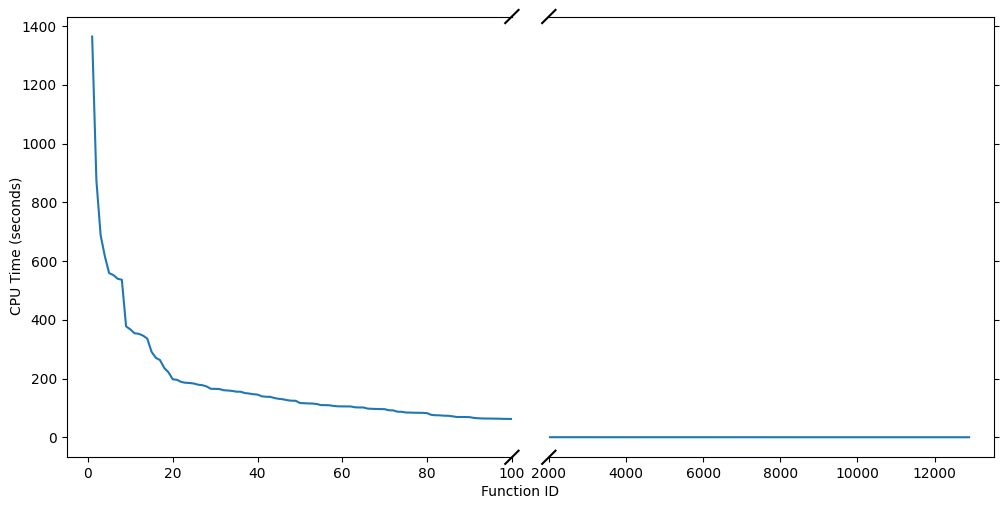

In [17]:
import matplotlib.pyplot as plt


fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor="w", figsize=(10, 5))
fig.tight_layout()

ax.plot(data["mean_cpu"])
ax2.plot(data["mean_cpu"])
ax.set_xlim(-5, 100)
ax2.set_xlim(2000, None)

# hide the spines between ax and ax2
ax.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax.yaxis.tick_left()
# ax2.tick_params(labelright="off")
ax2.yaxis.tick_right()

d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)


fig.text(0.5, 0, "Function ID", ha="center")
fig.text(-0.01, 0.5, "CPU Time (seconds)", va="center", rotation="vertical")

fig.savefig(figures_dir / "global_longtail.png")
fig.show()

In [18]:
# from scipy.stats import goodness_of_fit, genpareto


# res = goodness_of_fit(genpareto, data["mean_cpu"], statistic="ks")
# res

In [19]:
# from scipy.stats import goodness_of_fit, lomax

# res = goodness_of_fit(lomax, data["mean_cpu"], statistic="ks")
# res

# Test